In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

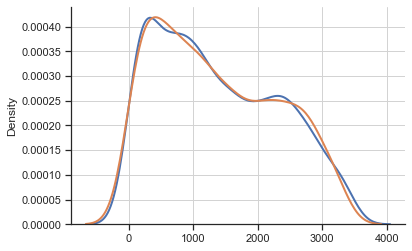

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_smarto_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

1 2.3770034313201904 2.3770034313201904
2 2.393718957901001 2.393718957901001
5 2.430047035217285 2.430047035217285
10 2.4870057106018066 2.4870057106018066
20 2.394068717956543 2.394068717956543
30 2.4071109294891357 2.4071109294891357


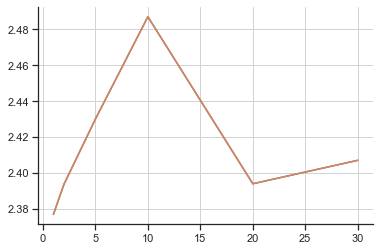

In [5]:
from survivors.ensemble import ParallelBootstrapCRAID
from survivors.tree import CRAID

param_bstr = {'aggreg_func': 'mean',
             'categ': categ, 'criterion': 'logrank', 
             'depth': 7, 'ens_metric_name': 'CI', 'l_reg': 0, 'leaf_model': 'base_zero_after', 
             'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 50, 
             'n_jobs': 20, 'size_sample': 0.6, 'weighted_tree': False}

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0, 'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 0.01, 'n_jobs': 20, 'n_jobs_loop': 1, 'signif': 1, 'woe': True}

n_js = [1, 2, 5, 10, 20, 30]
# n_js = [1, 2, 4, 8, 16, 32]
ft_s = []
t_s = []
for n_j in n_js:
    param_bstr['n_jobs'] = n_j
#     p['n_jobs'] = n_j
    
    time_start = time.time()
#     bstr = ParallelBootstrapCRAID(**param_bstr)
#     bstr.fit(X_tr, y_tr)
    
    tree = CRAID(**p)
    tree.fit(X_tr, y_tr)
    t_s.append(time.time() - time_start)
    
#     ens_metr_arr = bstr.tolerance_find_best(param_bstr["ens_metric_name"])
    ens_metr_arr = tree.tolerance_find_best(p["ens_metric_name"])
    
    ft_s.append(time.time() - time_start)
    print(n_j, t_s[-1], ft_s[-1])
    
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.show()
# auprc_by_obs_HO = metr.auprc(y_tr, y_HO, bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
# ibsrm_by_obs_HO = metr.ibs_remain(y_tr, y_HO, bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
# print(auprc_by_obs_HO)
# print(ibsrm_by_obs_HO)

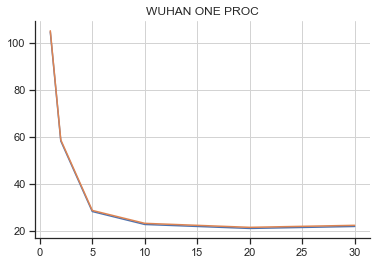

In [8]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN ONE PROC")
plt.show()

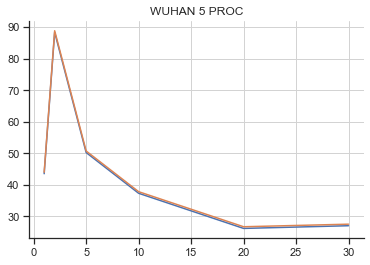

In [6]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN 5 PROC")
plt.show()

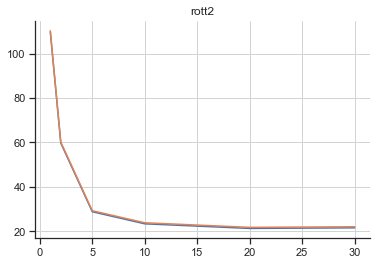

In [52]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("rott2")
plt.show()

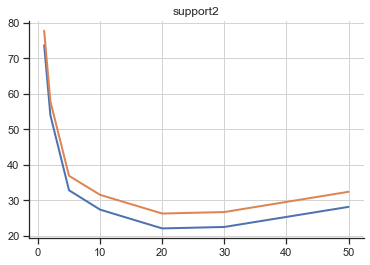

In [18]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("support2")
plt.show()

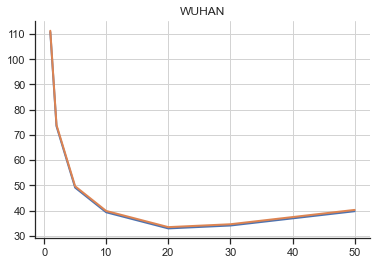

In [15]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN")
plt.show()

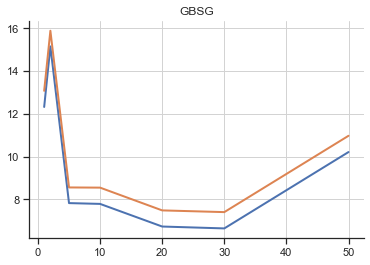

In [12]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("GBSG")
plt.show()

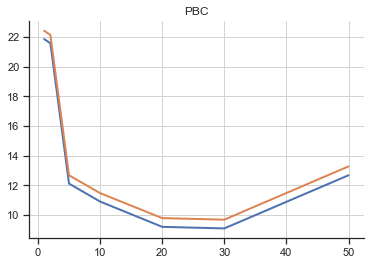

In [9]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("PBC")
plt.show()

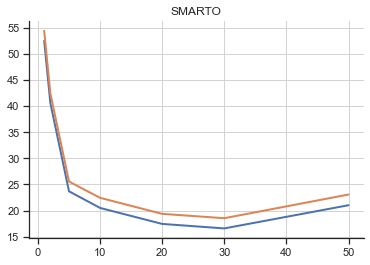

In [6]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("SMARTO")
plt.show()